##### All required packages

In [1]:
#!pip install gym_minigrid
#!pip install array2gif

# to create gym environment (test environment for DQN)
import gym
from gym import wrappers
from gym_minigrid.wrappers import *

# to store and process data
import random
import numpy as np
import matplotlib.pyplot as plt
from array2gif import write_gif

# to train a NN that approximates the Q function
import tensorflow as tf
from keras import layers
from keras.models import Model, load_model, clone_model
from keras.optimizers import RMSprop
from keras import backend as K
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from sentence_transformers import SentenceTransformer

# to pre-process the video frames (observation)
from skimage.color import rgb2gray
from skimage.transform import resize

# to build the experience replay
from collections import deque

# to communicate with the system / store trained models / visualize results
from sys import getsizeof
from datetime import datetime
import os.path
import time
import io
import base64
from IPython.display import HTML

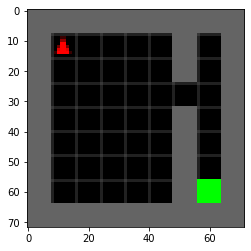

In [2]:
# create the simple crossing environment
env = gym.make('MiniGrid-SimpleCrossingS9N1-v0')
env = ReseedWrapper(env,seeds=[3])
env = RGBImgObsWrapper(env) # Get pixel observations
env = ImgObsWrapper(env) # Get rid of the 'mission' field

obs, reward, done, _ = env.step(0)
plt.imshow(obs)
plt.show()

In [4]:
# function to pre-process image frames
def pre_process(observation):
    processed_observation = np.uint8(resize(observation, (84, 84)) *255) #  gray scale image where pixel intensities are between 0-255
    return processed_observation


# function to generate one-hot-encoded masked action vector
def one_hot_encode_mask(target_action_idx, number_of_actions):
    return np.eye(number_of_actions)[np.array(target_action_idx).reshape(-1)]


# function defining the Q-network
def q_approx_model():
    
    num_of_actions = 3 # number of actions
    input_img_size = (84, 84, 3 * 3)  # input image size to model

    # inputs to model
    obs_input = layers.Input(input_img_size, name='4_stacked_input_frames') 
    actions_input = layers.Input((num_of_actions,), name='one_hot_encoded_action_mask')

    # normalize the grayscaled input frames
    normalized_obs = layers.Lambda(lambda x: x / 255.0, name='frame_normalization')(obs_input)

    # "The first hidden layer convolves 16 8×8 filters with stride 4 with the input image and applies a rectifier nonlinearity."
    convolution_1 = layers.convolutional.Conv2D( 16, (8, 8), strides=(4, 4), activation='relu')(normalized_obs)

    # "The second hidden layer convolves 32 4×4 filters with stride 2, again followed by a rectifier nonlinearity."
    convolution_2 = layers.convolutional.Conv2D( 32, (4, 4), strides=(2, 2), activation='relu')(convolution_1)

    # flattened second convolutional layer.
    convolution_2_flattened = layers.core.Flatten()(convolution_2)

    # "The final hidden layer is fully-connected and consists of 256 rectifier units."
    final_hidden = layers.Dense(256, activation='relu')(convolution_2_flattened)

    # "The output layer is a fully-connected linear layer with a single output for each valid action."
    output_layer = layers.Dense(num_of_actions, activation='linear')(final_hidden)

    # output multiplied by the mask
    masked_output = layers.Multiply(name='q_val')([output_layer, actions_input])

    # initialise the model
    model = Model(inputs = [obs_input, actions_input], outputs = masked_output)

    # model summary
    model.summary()

    # "We used the RMSProp algorithm""
    optimizer = RMSprop(lr=0.00025, rho=0.95, epsilon=0.01)
    
    model.compile(optimizer, loss='mse')

    return model


# function to store the observed information in the replay memory
def store_replay_memory(replay_memory, current_state_set, action, reward, current_states_w_nxt_state, is_next_terminate):
    replay_memory.append((current_state_set, action, reward, current_states_w_nxt_state, is_next_terminate))

    
# function to train the Q-network using random batches drawn from Replay Memory
def batch_train_q_network(replay_memory, model):

    num_of_actions = 3 # number of agent actions
    input_img_size = (84, 84, 3*3)  # input image size to model

    # batch size
    batch_size = 32

    # discounting factor (future reward decay rate)
    gamma = 0.99

    # draw a random mini-batch from the Replay Memory
    mini_batch = random.sample(replay_memory, batch_size)
    
    # create a placeholder to store `current state sets` from sampled batch
    current_states_set_history = np.zeros((batch_size, input_img_size[0]
                                                     , input_img_size[1]
                                                     , input_img_size[2]))
    
    # create a placeholder to store `current states with next states` from sampled batch
    current_states_set_w_nxt_history = np.zeros((batch_size, input_img_size[0]
                                                           , input_img_size[1]
                                                           , input_img_size[2]))
    
    # create a placeholder to store Q-value targets calculated during training 
    calculated_targets = np.zeros((batch_size,))

    # create placeholders to store actions, rewards and termination flags
    action, reward, is_next_terminate = [], [], []

    # transfer mini-batch data from Replay Memory to placeholders
    for idx, val in enumerate(mini_batch):
        current_states_set_history[idx] = val[0]
        action.append(val[1])
        reward.append(val[2])
        current_states_set_w_nxt_history[idx] = val[3]
        is_next_terminate.append(val[4])


    # generate next state Q-value estimates with current Q-network
    all_action_mask = np.ones((batch_size, num_of_actions))
    next_state_Q_values = model.predict([current_states_set_w_nxt_history, all_action_mask])

    # calculate target Q-values for sample using: r + gamma * max[Q(s',a')]
    # If next state is a terminal, set target to be -1 (negative reward - penalize termination)
    for i in range(batch_size):
        if is_next_terminate[i]:
            calculated_targets[i] = -1
        else:
            calculated_targets[i] = reward[i] + gamma * np.amax(next_state_Q_values[i])

    # create the mask layer for each selected action
    one_hot_encoded_action = one_hot_encode_mask(action, num_of_actions)

    # get target values only for the selected action
    one_hot_encoded_target = one_hot_encoded_action * calculated_targets[:, None]

    # train the q-network using mini-batch data
    H = model.fit([current_states_set_history, one_hot_encoded_action]
                  , one_hot_encoded_target
                  , epochs=1
                  , batch_size=batch_size
                  , verbose=0)

    # return the training loss
    return H.history['loss'][0]


# function to select an action from the Q-network using an epsilon-greedy policy
def select_action(current_state_set, epsilon, step, model, obs_step_num):

    # number of agent actions
    num_of_actions = 3

    if np.random.rand() <= epsilon or step <= obs_step_num:
        action = random.randrange(num_of_actions) # get the index of a random action
        return action + 1 # return the real action
    else:
        q_value = model.predict([current_state_set, np.ones(num_of_actions).reshape(1, num_of_actions)])
        action = np.argmax(q_value[0]) # get the index of the action with highest Q-value
        return action + 1 # return the real action

# function to generate intermediate rewards
def intermediate_rewards_function(three_frames, language_instruction):
    """This function takes 3 (consecutive) images/game frames and a language instruction and evaluates 
       if the agent's behaviour in the frames agrees with the given language instruction.
       
       It uses the the previously trained LIERN model and outputs a reward of `1' if agent's behaviour
       aligns with the given instruction (and `0' otherwise)."""
    
    ### CONVERTING IMAGES TO EMBEDDING VECTOR ###
    
    img_model = models.resnet50(pretrained=True)
    layer = img_model._modules.get('avgpool')

    # Set model to evaluation mode
    img_model.eval()

    def get_img_embeddings(image_array):
        """gets 3 input frames/images and converts them to a single embedding vector"""

        temp_imgs_l = []

        for image in image_array:
            temp_img = Image.fromarray(image).convert('RGB')
            temp_img = normalize(to_tensor(scaler(temp_img)))
            temp_imgs_l.append(temp_img)

        temp_imgs_l = torch.cat(temp_imgs_l)
        temp_imgs_l = temp_imgs_l.reshape((3,3,224,224))

        # create PyTorch Var. w/ pre-processed image
        t_img = Variable(temp_imgs_l)

        # create an empty vector to hold the embeddings vector
        img_embedding = torch.zeros(2048*3)

        # function to copy the output of the layer
        def copy_data(m, i, o):
            img_embedding.copy_(o.data.reshape(2048*3))

        # attach that function to the `avgpool` layer
        h = layer.register_forward_hook(copy_data)

        # run the model on the image
        img_model(t_img)

        # remove the copy function from the layer
        h.remove()

        # return the feature vector
        return img_embedding

    
    ### CONVERTING LANGUAGE INSTRUCTION TO EMBEDDING VECTOR ###
    
    sentence_model = SentenceTransformer('roberta-large-nli-stsb-mean-tokens')

    def get_sentence_embeddings(sentence_model, language_instruct):

        sentc_embedding = sentence_model.encode(language_instruct)

        return sentc_embedding.reshape(-1).tolist()
    
    
    ### GENERATING THE COMBINED EMBEDDINGS VECTOR (INPUT TO CLASSIFICATION MODEL) ###
    
    def get_combined_embeddings(img_embed, sentence_embed):

        return np.concatenate([img_embed, sentence_embed]).tolist()
    
    
    ### GENERATE INTERMEDIATE REWARDS USING SAVED MODEL ###
    
    class Classification_Net(nn.Module):

        def __init__(self, n_features):
            super(Classification_Net, self).__init__()
            self.fc1 = nn.Linear(n_features, int(7168/2))
            self.fc2 = nn.Linear(int(7168/2), int(7168/10))
            self.fc3 = nn.Linear(int(7168/10), int(7168/100))
            self.fc4 = nn.Linear(int(7168/100), 1)

        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = F.relu(self.fc3(x))
            return torch.sigmoid(self.fc4(x))

    # load the previously trained model parameters
    classify_net = torch.load('classify_model.pth')

    def get_probability(model, combined_embed):
        
        classify_net = model
        embed_input = torch.from_numpy(np.array(combined_embed)).float()
        y_pred - classify_net(embed_input)
        return y_pred

    def generate_interim_reward(predicted_prob):

        if predicted_prob > .5:
            return 1
        else:
            return 0
        
    img_embeddings = get_img_embeddings(three_frames)
    sentence_embeddings =  get_sentence_embeddings(sentence_model, language_instruction)
    combined_embeddings = get_combined_embeddings(img_embeddings,sentence_embeddings)
    probability = get_probability(classify_net,combined_embeddings)
    interim_reward = generate_interim_reward(probability)
    
    return interim_reward

In [1]:
# training and testing configurations:

configs = {  'train_dir'          : './train_dir/' # directory where to write event logs and checkpoint
            ,'restore_model_path' :  './train_dir/grid_world_20200912050215.h5' # Path of the restore model file
            ,'resume'             : False # resume training from previous a previous model
            , 'use_iter_rewards'  : False # whether to start generating language-based intermediate rewards
            }

In [14]:
def dqn_algo_train():

    # create the simple crossing environment 
    random_seed = 0 # np.random.randint(1000) ## uncomment this to create stochastic enviroments
    env = gym.make('MiniGrid-SimpleCrossingS9N1-v0')
    env = ReseedWrapper(env,seeds=[random_seed])
    env = RGBImgObsWrapper(env) # Get pixel observations
    env = ImgObsWrapper(env) # Get rid of the 'mission' field

    # parameter initialization
    training_epi_limit = 100000 # number of episodes to training the Q-network
    obs_step_num = 50000 # number of steps to observe (no training)
    replay_memory_len = 400000  # how many previous states to remember

    target_model_refresh_steps = 20000 # number of steps to refresh the target model weights

    inititial_epsilon = 1.0 # starting epsilon for the policy
    resume_epsilon = 0.5 # training resume epsilon for the policy 
    final_epsilon = 0.1 # final epsilon for the policy
    epsilon_annealed_steps = 500000 # number of steps to linearly anneal epsilon from 1.0 to 0.1

    epsilon_decay = (inititial_epsilon - final_epsilon) / epsilon_annealed_steps # epsilon decay per annealed step

    manual_instruction_count = 0 # number of steps to continue without asking for language instructions
    
    episode_num = 0 # store episode
    global_step_num = 0 # store global step number
    
    # initialize the fixed length Experience Replay memory
    memory = deque(maxlen = replay_memory_len)

    # initialize epsilon
    epsilon = inititial_epsilon
    
    # if DQN training is resumed from the last checkpoint
    # set a decayed (0.5) epsilon value to restrict exploration 
    # (assuming previous training sessions have done most exploration)
    if configs['resume']:
        model = load_model(configs['restore_model_path'])
        epsilon = resume_epsilon
    else:
        model = q_approx_model()

    # clone most recent Q-network to calculate target
    model_target = clone_model(model)
    model_target.set_weights(model.get_weights())

    # initialize the Q-learning episodes-loop
    while episode_num < training_epi_limit:

        # flags to identify if an episode/game has terminated
        terminated = False
        
  
        # variables to information per episode (a game)
        score = 0         # store game score (per episode/game)
        step = 0          # store steps taken (per episode/game)    
        loss = 0.0        # store loss value per episode/game
        
        # reset the environment
        env.reset()

        # get the first observation and preprocess it
        first_obs, _, _, _ = env.step(1)
        first_state = pre_process(first_obs)

        # duplicate the first observations 3 times to create history
        history = np.stack((first_state, first_state, first_state, first_state), axis=2)
        history = np.reshape([history], (1, 84, 84, 3*3))
        
        # initialize a loop within an episode/game
        while not terminated:
            
            inter_reward = 0 # set any intermediate rewards to zero 

            # get action for the current history and go one step in environment
            action = select_action(history, epsilon, global_step_num, model_target, obs_step_num)

            # decay epsilon after observation period
            if epsilon > final_epsilon and global_step_num > obs_step_num:
                epsilon -= epsilon_decay

            # record environment's response for the action
            observation, reward, terminated, info = env.step(action)

            # preprocess the observation and store as next state to new history
            next_state = pre_process(observation)
            next_state = np.reshape([next_state], (1, 84, 84, 3*1))
            next_history = np.append(next_state, history[:, :, :, :3*2], axis=3)
            
            # generate intermediate rewards (only if triggered AND 1000 time-steps has passed since last instruction)
            ## TO-DO : Implement the moving-avg-based threshold
            if configs['use_iter_rewards'] and manual_instruction_count % 1000 == 0:
        
                # diplay last 3 game frames
                for img in history[:, :, :, -3*3:]:
                    plt.imshow(img)
                    plt.show()
                    
                language_instruction = input("Please provide the instruction to the agent (based on last 3 frames): ")
                inter_reward = intermediate_rewards_function(history[:, :, :, -3*3:], language_instruction)
                manual_instruction_count -= 1
                
            reward = reward + inter_reward
            
            # store the current step data to replay memory
            store_replay_memory(memory, history, (action-1), reward, next_history, terminated)

            # initiate the Q-network training if observation period is over
            if global_step_num > obs_step_num:

                # perform batch training for 1-epoch
                loss = loss + batch_train_q_network(memory, model)

                # update the target model weights every 10,000 steps
                if global_step_num % target_model_refresh_steps == 0:  
                    model_target.set_weights(model.get_weights())

            # update the in game/episode score
            score += reward

            # assign new state to current state
            history = next_history
            
            # increment the global step number and in game/episode step number
            global_step_num += 1
            step += 1

            # display information per episode/game at termination
            if terminated:
                print(f'episode: {episode_num}, score: {score}, global_step_num: {global_step_num}, avg loss: {loss/float(step)}, step: {step}, replay memory length: {len(memory)}')

                # save the model weights after every 500 episodes (and at the end of the training loop)
                if episode_num % 500 == 0 or (episode_num + 1) == training_epi_limit:
                    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
                    file_name = f"grid_world_{now}.h5"
                    model_path = os.path.join(configs['train_dir'], file_name)
                    model.save(model_path)

                episode_num += 1


In [ ]:
dqn_algo_train()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
4_stacked_input_frames (InputLa [(None, 84, 84, 12)] 0                                            
__________________________________________________________________________________________________
frame_normalization (Lambda)    (None, 84, 84, 12)   0           4_stacked_input_frames[0][0]     
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 20, 20, 16)   12304       frame_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 9, 9, 32)     8224        conv2d[0][0]                     
_______________________________________________________________________________________

### Training results:

In [23]:
frames = []

def dqn_algo_test(test_epi=1):
    # create the simple crossing environment 
    random_seed = 0 # np.random.randint(1000) ## uncomment this to create stochastic enviroments
    env = gym.make('MiniGrid-SimpleCrossingS9N1-v0')
    env = ReseedWrapper(env,seeds=[random_seed])
    env = RGBImgObsWrapper(env) # Get pixel observations
    env = ImgObsWrapper(env) # Get rid of the 'mission' field

    test_episodes = test_epi # number of episodes to run test

    # store the results 
    env = wrappers.Monitor(env, "/results/", force=True)

    episode_number = 0 # initialize episode count
    epsilon = 0.001 # initialize epsilon - keep to minimum because no need to explore
    obs_step_num = 0 # no need to observe any data

    # to use the trained network
    global_step = 1000001  # 
    model = load_model(configs['restore_model_path'])

    # run the test game loop
    while episode_number < test_episodes:

        # flags to identify if an episode/game has terminated
        terminated = False

        # variables to information per episode (a game)
        score = 0         # store game score (per episode/game)   
        
        # reset the environment
        env.reset()
        #observe = env.reset()

        # get the first observation and preprocess it
        first_obs, _, _, _ = env.step(1)
        first_state = pre_process(first_obs)

        # duplicate the first observations 4 times to create history
        history = np.stack((first_state, first_state, first_state, first_state), axis=2)
        history = np.reshape([history], (1, 84, 84, 3*3))

        # initialize a loop within an episode/game
        while not terminated:

            frames.append(np.moveaxis(env.render("rgb_array"), 2, 0))

            # get action for the current history and go one step in environment
            action = select_action(history, epsilon, global_step, model, obs_step_num)

            # record environment's response for the action
            observation, reward, terminated, info = env.step(action)

            # preprocess the observation and store as next state to new history
            next_state = pre_process(observation)
            next_state = np.reshape([next_state], (1, 84, 84, 1*3))
            next_history = np.append(next_state, history[:, :, :, :2*3], axis=3)

            # update the in game/episode score
            score += reward

            # assign new state to current state
            history = next_history

            # increment the global step number
            global_step += 1
            
            # store information at the episode termination
            if terminated:
                write_gif(np.array(frames), f'test_epi_{episode_number}'+".gif", fps=1/0.1)
                episode_number += 1
                print(f"episode: {episode_number}, score: {score}")
                env.close()
          

In [24]:
dqn_algo_test(9)

episode: 1, score: 0
episode: 2, score: 0
episode: 3, score: 0
episode: 4, score: 0
episode: 5, score: 0
episode: 6, score: 0
episode: 7, score: 0
episode: 8, score: 0
episode: 9, score: 0
